In [1]:
# Import Libraies
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
def convert_lat_lon(value):
    """
    Converts latitude/longitude strings (e.g., '6132.9236N') into decimal format.
    """
    match = re.match(r"([\d.]+)([NSEW])", str(value))  # Extract number & direction
    if match:
        num, direction = match.groups()
        num = float(num)
        if direction in ["S", "W"]:  # South & West are negative
            num = -num
        return num
    return np.nan  # Handle errors

def remove_outliers_iqr(df, columns):
    """
    Removes outliers from specified columns using the IQR method.
    """
    for col in columns:
        Q1 = df[col].quantile(0.25)  # First Quartile (25%)
        Q3 = df[col].quantile(0.75)  # Third Quartile (75%)
        IQR = Q3 - Q1  # Interquartile Range
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Filter out outliers
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

    return df

def evaluate_model(y_true, y_pred, model_name):
    """
    Evaluates model training performance results
    """
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    print(f"Model: {model_name}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"R² Score: {r2:.4f}")

def check_null_in_df(dataframe):
    for name, df in dataframe.items():
        print(f"{name}: {df.isnull().sum().sum()} missing values in the dataset.")

    print("\nTotal missing values after merging:")
    print(dataframe.isnull().sum())

In [28]:
data_folder = "/content"

files = {
    "fuelDensity.csv": "fuelDensity",
    "fuelTemp.csv": "fuelTemp",
    "fuelVolumeFlowRate.csv": "fuelVolumeFlowRate",
    "inclinometer-raw.csv": "inclinometer",
    "latitude.csv": "latitude",
    "level1median.csv": "level1median",
    "level2median.csv": "level2median",
    "longitude.csv": "longitude",
    "longitudinalWaterSpeed.csv": "longitudinalWaterSpeed",
    "portPitch.csv": "portPitch",
    "portRudder.csv": "portRudder",
    "speedKmh.csv": "speedKmh",
    "speedKnots.csv": "speedKnots",
    "starboardPitch.csv": "starboardPitch",
    "starboardRudder.csv": "starboardRudder",
    "trackDegreeMagnetic.csv": "trackDegreeMagnetic",
    "trackDegreeTrue.csv": "trackDegreeTrue",
    "trueHeading.csv": "trueHeading",
    "windSpeed.csv": "windSpeed",
    "windAngle.csv": "windAngle"

}


dataframes = {}

for file_name, col_name in files.items():
    file_path = os.path.join(data_folder, file_name)

    if not os.path.exists(file_path):
        print(f"File not found: {file_name}, aborting...")
        continue

    df = pd.read_csv(file_path, header=None, names=["timestamp", col_name])

    df['timestamp'] = pd.to_datetime(df['timestamp'], origin='unix', unit='ns') + pd.DateOffset(years=20)
    df['timestamp'] = df['timestamp'].astype(str)

    dataframes[col_name] = df

df_merged = None
for name, df_new in dataframes.items():
    if df_merged is None:
        df_merged = df_new
    else:
        df_merged = pd.merge(df_merged, df_new, on="timestamp", how="outer")

df_merged = df_merged.sort_values(by="timestamp")

df_merged["EnergyConsumption"] = (df_merged["fuelDensity"] * df_merged["fuelVolumeFlowRate"] * 3600 * 24) / 1000

df_merged.head()

,timestamp,fuelDensity,fuelTemp,fuelVolumeFlowRate,inclinometer,latitude,level1median,level2median,longitude,longitudinalWaterSpeed,...,speedKmh,speedKnots,starboardPitch,starboardRudder,trackDegreeMagnetic,trackDegreeTrue,trueHeading,windSpeed,windAngle,EnergyConsumption
0,2010-02-03 04:08:15.128184147,NaN,NaN,NaN,NaN,NaN,16.871168,13.935757,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-02-03 04:08:15.130693130,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.1,0.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2010-02-03 04:08:15.130928380,NaN,NaN,NaN,357.25,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2010-02-03 04:08:15.131517480,NaN,NaN,NaN,NaN,NaN,16.830462,13.953643,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2010-02-03 04:08:15.134850813,NaN,NaN,NaN,NaN,NaN,16.779580,13.912760,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
print("Dataset shape uncleaned and merged:", df_merged.shape)

Dataset shape uncleaned and merged: (19045464, 22)


In [5]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19045464 entries, 0 to 19045463
Data columns (total 22 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   timestamp               object 
 1   fuelDensity             float64
 2   fuelTemp                float64
 3   fuelVolumeFlowRate      float64
 4   inclinometer            float64
 5   latitude                object 
 6   level1median            float64
 7   level2median            float64
 8   longitude               object 
 9   longitudinalWaterSpeed  float64
 10  portPitch               float64
 11  portRudder              float64
 12  speedKmh                float64
 13  speedKnots              float64
 14  starboardPitch          float64
 15  starboardRudder         float64
 16  trackDegreeMagnetic     float64
 17  trackDegreeTrue         float64
 18  trueHeading             float64
 19  windSpeed               float64
 20  windAngle               float64
 21  EnergyConsumption       float

In [6]:
check_null_in_df(df_merged)

timestamp: 0 missing values in the dataset.
fuelDensity: 17418140 missing values in the dataset.
fuelTemp: 17418140 missing values in the dataset.
fuelVolumeFlowRate: 17418140 missing values in the dataset.
inclinometer: 15485787 missing values in the dataset.
latitude: 16367751 missing values in the dataset.
level1median: 15065690 missing values in the dataset.
level2median: 15204670 missing values in the dataset.
longitude: 16367768 missing values in the dataset.
longitudinalWaterSpeed: 18497172 missing values in the dataset.
portPitch: 17319388 missing values in the dataset.
portRudder: 17319388 missing values in the dataset.
speedKmh: 17278558 missing values in the dataset.
speedKnots: 17278556 missing values in the dataset.
starboardPitch: 17319388 missing values in the dataset.
starboardRudder: 17319388 missing values in the dataset.
trackDegreeMagnetic: 17278990 missing values in the dataset.
trackDegreeTrue: 17278985 missing values in the dataset.
trueHeading: 17605925 missing 

In [7]:
df_merged.ffill(inplace=True)
df_merged.bfill(inplace=True)

In [8]:
check_null_in_df(df_merged)

timestamp: 0 missing values in the dataset.
fuelDensity: 0 missing values in the dataset.
fuelTemp: 0 missing values in the dataset.
fuelVolumeFlowRate: 0 missing values in the dataset.
inclinometer: 0 missing values in the dataset.
latitude: 0 missing values in the dataset.
level1median: 0 missing values in the dataset.
level2median: 0 missing values in the dataset.
longitude: 0 missing values in the dataset.
longitudinalWaterSpeed: 0 missing values in the dataset.
portPitch: 0 missing values in the dataset.
portRudder: 0 missing values in the dataset.
speedKmh: 0 missing values in the dataset.
speedKnots: 0 missing values in the dataset.
starboardPitch: 0 missing values in the dataset.
starboardRudder: 0 missing values in the dataset.
trackDegreeMagnetic: 0 missing values in the dataset.
trackDegreeTrue: 0 missing values in the dataset.
trueHeading: 0 missing values in the dataset.
windSpeed: 0 missing values in the dataset.
windAngle: 0 missing values in the dataset.
EnergyConsumpti

In [9]:
df_merged.dropna(inplace=True)
df_merged.shape

(19045464, 22)

In [10]:
df_merged.duplicated().sum()

0

In [11]:
df_merged["latitude"] = df_merged["latitude"].apply(convert_lat_lon)
df_merged["longitude"] = df_merged["longitude"].apply(convert_lat_lon)

print(df_merged[["latitude", "longitude"]].head())

    latitude  longitude
0  6132.9236  -649.1143
1  6132.9236  -649.1143
2  6132.9236  -649.1143
3  6132.9236  -649.1143
4  6132.9236  -649.1143


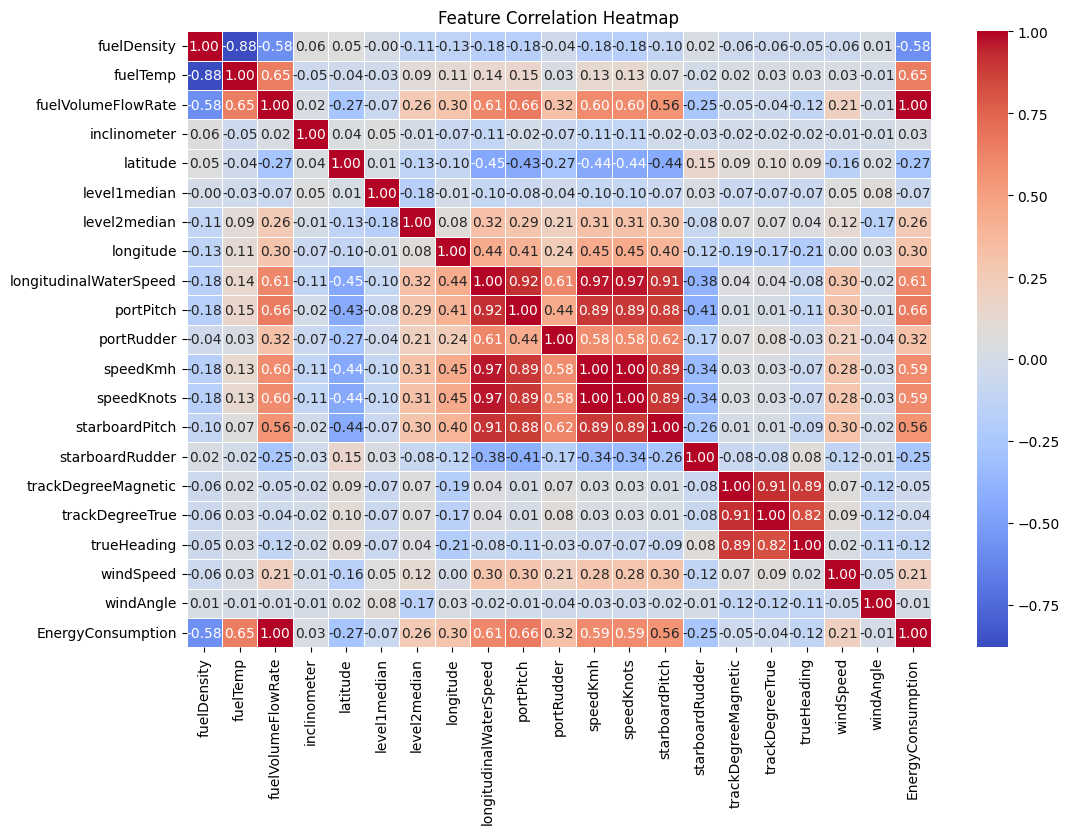

In [12]:
plt.figure(figsize=(12, 8))
correlation_matrix = df_merged.drop(columns=["timestamp"]).corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

In [13]:
threshold = 0.50

high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            high_corr_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j], correlation_matrix.iloc[i, j]))

print("Highly Correlated Features (|r| > 0.50):")
for feature1, feature2, corr_value in high_corr_pairs:
    print(f"{feature1} ↔ {feature2} (Correlation: {corr_value:.2f})")

Highly Correlated Features (|r| > 0.50):
fuelTemp ↔ fuelDensity (Correlation: -0.88)
fuelVolumeFlowRate ↔ fuelDensity (Correlation: -0.58)
fuelVolumeFlowRate ↔ fuelTemp (Correlation: 0.65)
longitudinalWaterSpeed ↔ fuelVolumeFlowRate (Correlation: 0.61)
portPitch ↔ fuelVolumeFlowRate (Correlation: 0.66)
portPitch ↔ longitudinalWaterSpeed (Correlation: 0.92)
portRudder ↔ longitudinalWaterSpeed (Correlation: 0.61)
speedKmh ↔ fuelVolumeFlowRate (Correlation: 0.60)
speedKmh ↔ longitudinalWaterSpeed (Correlation: 0.97)
speedKmh ↔ portPitch (Correlation: 0.89)
speedKmh ↔ portRudder (Correlation: 0.58)
speedKnots ↔ fuelVolumeFlowRate (Correlation: 0.60)
speedKnots ↔ longitudinalWaterSpeed (Correlation: 0.97)
speedKnots ↔ portPitch (Correlation: 0.89)
speedKnots ↔ portRudder (Correlation: 0.58)
speedKnots ↔ speedKmh (Correlation: 1.00)
starboardPitch ↔ fuelVolumeFlowRate (Correlation: 0.56)
starboardPitch ↔ longitudinalWaterSpeed (Correlation: 0.91)
starboardPitch ↔ portPitch (Correlation: 0.88

In [14]:
selected_features = [
    "timestamp", "fuelVolumeFlowRate","fuelTemp", "longitudinalWaterSpeed",
    "speedKmh", "portPitch", "starboardPitch"
]

In [15]:
selected_features[1:]

['fuelVolumeFlowRate',
 'fuelTemp',
 'longitudinalWaterSpeed',
 'speedKmh',
 'portPitch',
 'starboardPitch']

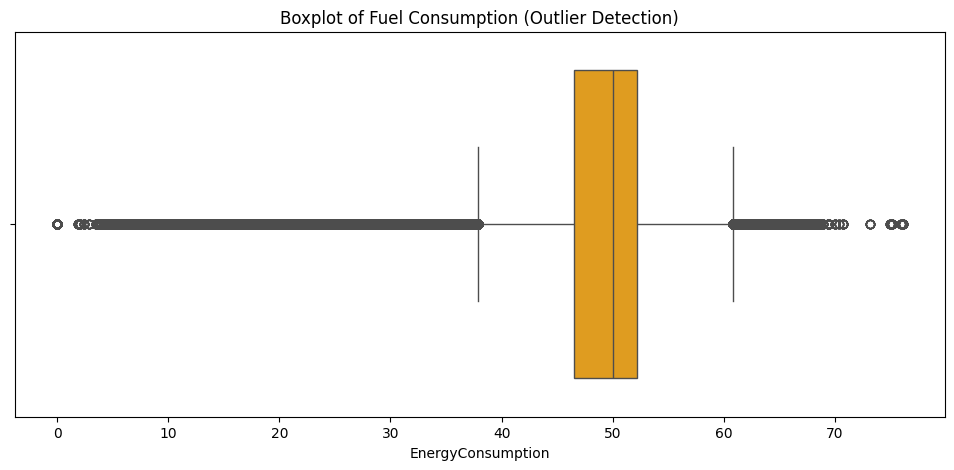

In [16]:
plt.figure(figsize=(12, 5))
sns.boxplot(x=df_merged["EnergyConsumption"], color="orange")
plt.title("Boxplot of Fuel Consumption (Outlier Detection)")
plt.show()

In [17]:
# Apply Outlier Removal
df_cleaned = remove_outliers_iqr(df_merged, selected_features[1:])

In [18]:
print(f"Shape before outlier removal: {df_merged.shape}")
print(f"Shape after outlier removal: {df_cleaned.shape}")

Shape before outlier removal: (19045464, 22)
Shape after outlier removal: (13271802, 22)


In [19]:
# Ensure timestamp is in datetime format
df_cleaned["timestamp"] = pd.to_datetime(df_cleaned["timestamp"])

# Grouping Data by Hour
df_hourly = df_cleaned.resample('H', on='timestamp').mean().reset_index()

# Extracting Time Features After Aggregation
df_hourly["year"] = df_hourly["timestamp"].dt.year
df_hourly["month"] = df_hourly["timestamp"].dt.month
df_hourly["day"] = df_hourly["timestamp"].dt.day
df_hourly["hour"] = df_hourly["timestamp"].dt.hour
df_hourly["minute"] = df_hourly["timestamp"].dt.minute
df_hourly["second"] = df_hourly["timestamp"].dt.second
df_hourly["day_of_week"] = df_hourly["timestamp"].dt.dayofweek  # Monday=0, Sunday=6
df_hourly["week_of_year"] = df_hourly["timestamp"].dt.isocalendar().week
df_hourly["is_weekend"] = (df_hourly["day_of_week"] >= 5).astype(int)

# Update cleaned dataset
df_cleaned = df_hourly

print("Data successfully aggregated hourly and processed!")
print(f"Final dataset shape after hourly aggregation: {df_cleaned.shape}")


<ipython-input-19-e2f31b1d1601>:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df_cleaned.resample('H', on='timestamp').mean().reset_index()


Data successfully aggregated hourly and processed!
Final dataset shape after hourly aggregation: (14, 31)


In [20]:
df_cleaned.head()

,timestamp,fuelDensity,fuelTemp,fuelVolumeFlowRate,inclinometer,latitude,level1median,level2median,longitude,longitudinalWaterSpeed,...,EnergyConsumption,year,month,day,hour,minute,second,day_of_week,week_of_year,is_weekend
0,2010-02-03 04:00:00,0.925239,97.916780,0.662200,357.266625,6146.772687,16.691586,14.730024,-642.080168,19.821293,...,52.936618,2010,2,3,4,0,0,2,5,0
1,2010-02-03 05:00:00,0.926046,96.876053,0.650679,357.280359,6145.799279,16.830265,14.810622,-641.640374,19.678714,...,52.060772,2010,2,3,5,0,0,2,5,0
2,2010-02-03 06:00:00,0.926594,96.648900,0.650156,357.294833,6145.243959,16.720093,14.879212,-641.217929,19.761129,...,52.049691,2010,2,3,6,0,0,2,5,0
3,2010-02-03 07:00:00,0.925922,97.765952,0.647179,357.351729,6144.892310,16.825883,14.937630,-639.785748,19.826028,...,51.773886,2010,2,3,7,0,0,2,5,0
4,2010-02-03 08:00:00,0.925893,97.532695,0.633341,357.180407,6145.961979,16.573452,14.833721,-639.609875,19.948865,...,50.665148,2010,2,3,8,0,0,2,5,0


In [21]:
print("Data successfully loaded and processed!")
print(f"Final dataset shape: {df_cleaned.shape}")

selected_features = [
'fuelVolumeFlowRate',
 'fuelTemp',
 'longitudinalWaterSpeed',
 'speedKmh',
 'portPitch',
 'starboardPitch'
]

# Target Variable
target = "EnergyConsumption"

# Extract Selected Features
X = df_cleaned[selected_features]
y = df_cleaned[target]

print(X.head(), y.head())

Data successfully loaded and processed!
Final dataset shape: (14, 31)
   fuelVolumeFlowRate   fuelTemp  longitudinalWaterSpeed   speedKmh  \
0            0.662200  97.916780               19.821293  37.547470   
1            0.650679  96.876053               19.678714  37.075199   
2            0.650156  96.648900               19.761129  36.881095   
3            0.647179  97.765952               19.826028  37.567046   
4            0.633341  97.532695               19.948865  37.458262   

   portPitch  starboardPitch  
0   8.585840        8.449362  
1   8.483067        8.384448  
2   8.502141        8.417376  
3   8.501750        8.442843  
4   8.456708        8.390855   0    52.936618
1    52.060772
2    52.049691
3    51.773886
4    50.665148
Name: EnergyConsumption, dtype: float64


In [22]:
# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, shuffle=False)

# Print dataset shape
print(f"Training data shape: {X_train.shape}, Test data shape: {X_test.shape}")

Training data shape: (11, 6), Test data shape: (3, 6)


In [23]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression()

In [24]:
from sklearn.linear_model import ElasticNet

elastic_model = ElasticNet(alpha=0.01, l1_ratio=0.5)
elastic_model.fit(X_train, y_train)

ElasticNet(alpha=0.01)

In [25]:
y_pred_lr = lr_model.predict(X_test)

In [26]:
y_pred_elastic = elastic_model.predict(X_test)

In [27]:
# Evaluating Models
evaluate_model(y_test, y_pred_lr, "Linear Regression")
evaluate_model(y_test, y_pred_elastic, "ElasticNet Regression")

Model: Linear Regression
Mean Absolute Error (MAE): 0.1566
Mean Squared Error (MSE): 0.0387
Root Mean Squared Error (RMSE): 0.1967
R² Score: 0.8826
Model: ElasticNet Regression
Mean Absolute Error (MAE): 0.1832
Mean Squared Error (MSE): 0.0455
Root Mean Squared Error (RMSE): 0.2134
R² Score: 0.8619


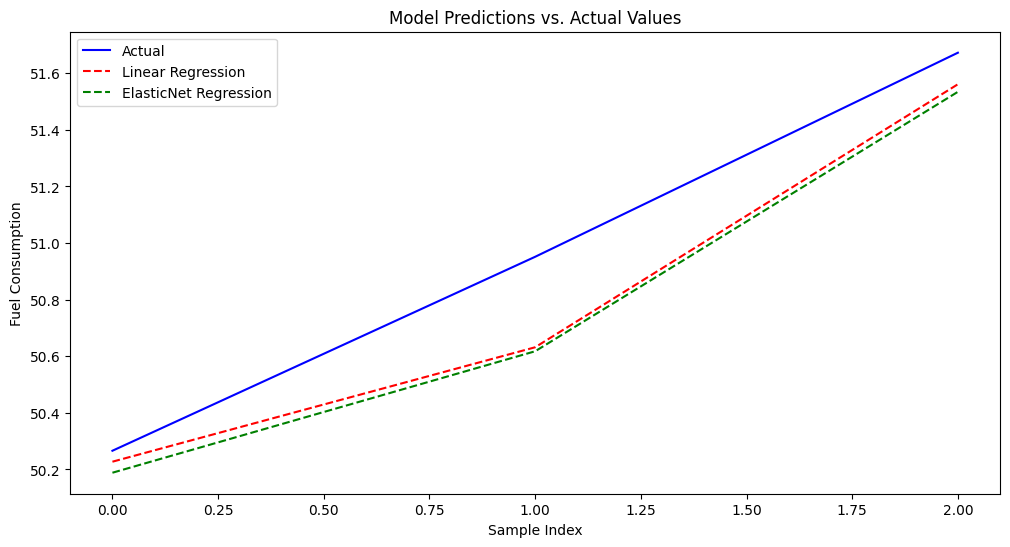

In [30]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.values[:100], label="Actual", linestyle="-", color="blue")
plt.plot(y_pred_lr[:100], label="Linear Regression", linestyle="--", color="red")
plt.plot(y_pred_elastic[:100], label="ElasticNet Regression", linestyle="--", color="green")
plt.xlabel("Sample Index")
plt.ylabel("Fuel Consumption")
plt.title("Model Predictions vs. Actual Values")
plt.legend()
plt.show()